In [1]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://repo.ai.gato/registry/repository/pypi-proxy/simple
  Using cached http://repo.ai.gato/registry/repository/pypi-proxy/packages/triton/3.2.0/triton-3.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (253.1 MB)
  Using cached http://repo.ai.gato/registry/repository/pypi-proxy/packages/sympy/1.13.1/sympy-1.13.1-py3-none-any.whl (6.2 MB)


In [2]:
# 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# 데이터셋 로드하기

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 32 # 128도 가능
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 데이터셋의 클래스 개수 확인
classes = train_dataset.classes
print(f"데이터셋 클래스 수: {len(classes)}")

데이터셋 클래스 수: 100


In [43]:
# GAN  - Generator

class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_dim=32*32*3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), 3, 32, 32)


In [44]:
# GAN -  Discriminator

class Discriminator(nn.Module):
    def __init__(self, img_dim=32*32*3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


In [45]:
# 모델 initialization

latent_dim = 100

generator = Generator(latent_dim)

discriminator = Discriminator()

In [47]:
# 손실 함수 & 옵티마이저 설정

adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.00008, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00008, betas=(0.5, 0.999))

In [48]:
# 학습

    # 시각화를 위한 리스트
g_loss_history = []
d_loss_history = []

# 학습
epochs = 50 # gan 뿐만 아니라 cgan에도 적용


for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_data_loader):

        # real image
        real_imgs = imgs
        real_labels = torch.ones(imgs.size(0), 1)

        # created image
        z = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = generator(z)
        fake_labels = torch.zeros(imgs.size(0), 1)

        # Discriminator - train
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Generator - train
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()


    # loss 저장
    g_loss_history.append(g_loss.item())
    d_loss_history.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{epochs}] D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

[Epoch 1/50] D Loss: 0.021477198228240013 | G Loss: 5.132894992828369
[Epoch 2/50] D Loss: 0.0458066463470459 | G Loss: 5.0398664474487305
[Epoch 3/50] D Loss: 0.05860746651887894 | G Loss: 5.315633773803711
[Epoch 4/50] D Loss: 0.12397454679012299 | G Loss: 4.2514543533325195
[Epoch 5/50] D Loss: 0.5885100364685059 | G Loss: 5.347033977508545
[Epoch 6/50] D Loss: 0.2658584415912628 | G Loss: 5.323160171508789
[Epoch 7/50] D Loss: 0.09236645698547363 | G Loss: 4.668304443359375
[Epoch 8/50] D Loss: 0.2062147557735443 | G Loss: 4.784779071807861
[Epoch 9/50] D Loss: 0.12924450635910034 | G Loss: 3.5684893131256104
[Epoch 10/50] D Loss: 0.29304075241088867 | G Loss: 3.6153500080108643
[Epoch 11/50] D Loss: 0.20590971410274506 | G Loss: 3.178154945373535
[Epoch 12/50] D Loss: 0.5170401334762573 | G Loss: 2.772705078125
[Epoch 13/50] D Loss: 0.32081323862075806 | G Loss: 2.535078287124634
[Epoch 14/50] D Loss: 0.3977988362312317 | G Loss: 2.4340267181396484
[Epoch 15/50] D Loss: 0.48955538

In [ ]:
# GAN Generator, Discriminator 시각화

epochs_range = range(1, len(g_loss_history) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, g_loss_history, linestyle='-', label="Generator Loss")
plt.plot(epochs_range, d_loss_history, linestyle='--', label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GAN Loss Comparison")
plt.ylim(0, max(max(g_loss_history), max(d_loss_history)) * 1.1)  # 적절한 y축 범위 설정
plt.legend()
plt.grid(True)
plt.show()

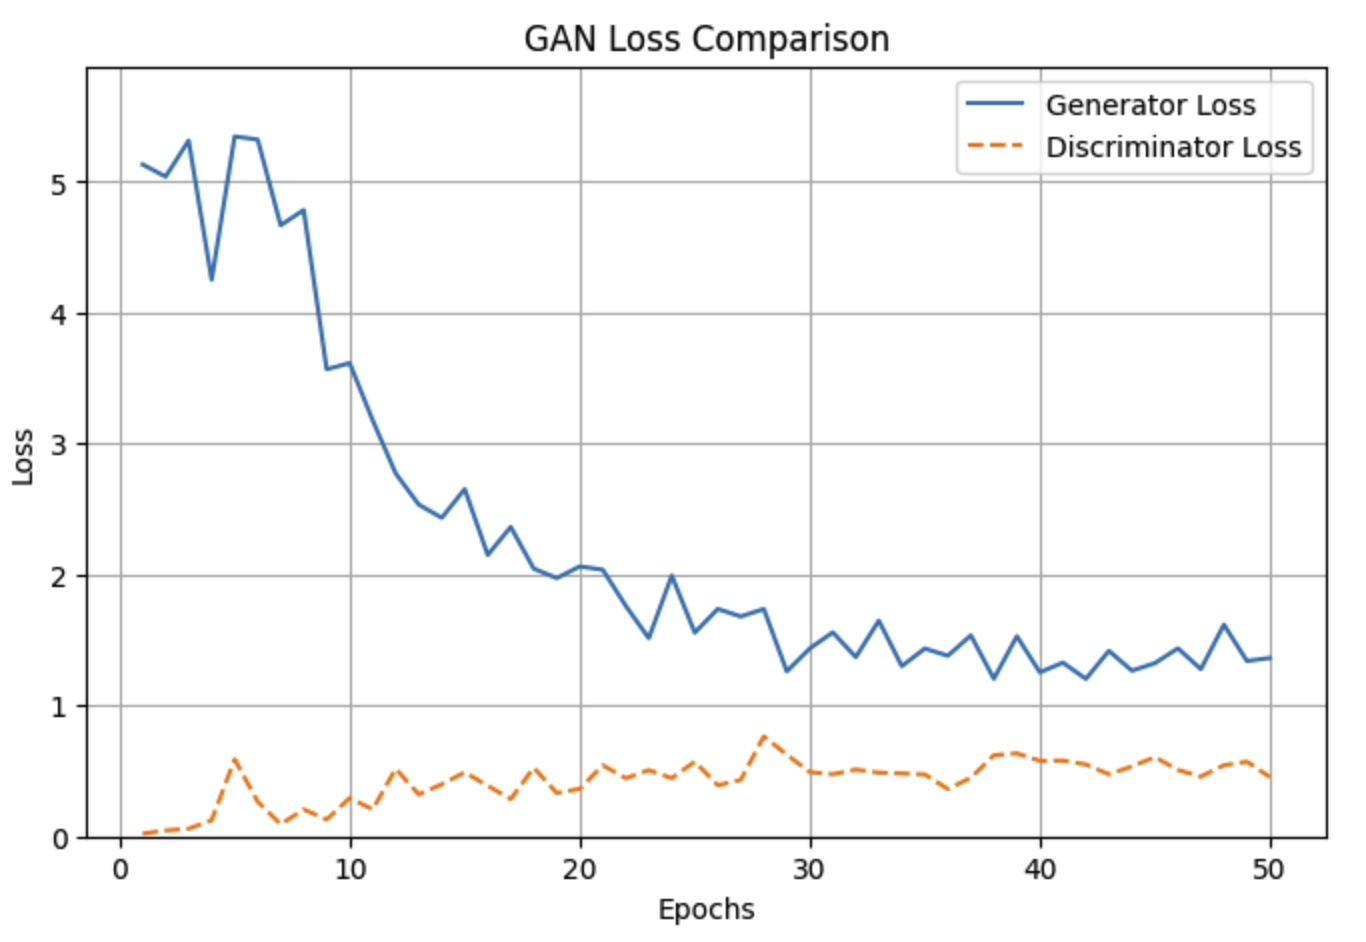


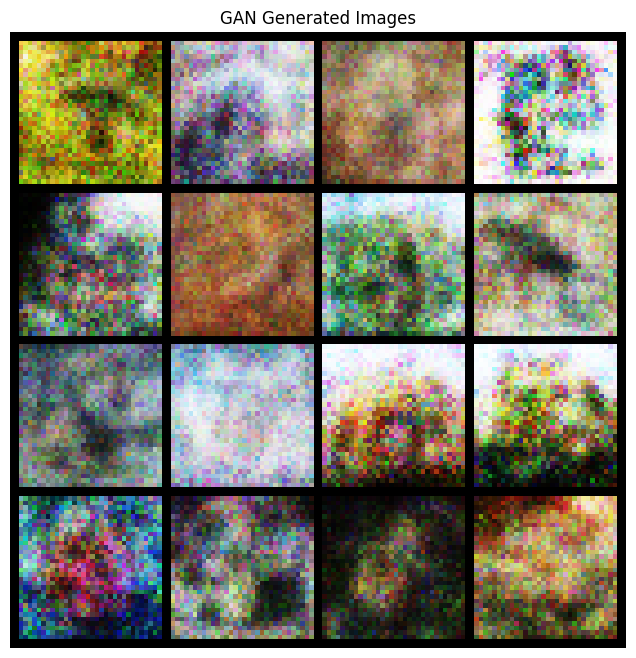

In [50]:
# 생성된 이미지 시각화

# 학습 결과 시각화
def generate_images(generator, num_images=16, latent_dim=100, device = "cuda"):

    generator.to(device) # 오류 해결 : Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

    generator.eval()
    noise = torch.randn(num_images, latent_dim, device=device)

    with torch.no_grad():
        fake_images = generator(noise)

    fake_images = (fake_images + 1) / 2 # 이미지 정규화 해제

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("GAN Generated Images")
    plt.imshow(vutils.make_grid(fake_images.cpu(), nrow=4, padding=2, normalize=False).permute(1, 2, 0))
    plt.show()

# Generator가 학습된 device에 맞게 자동 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generate_images(generator, device=device)

In [7]:
# CGAN generator

class CGAN_Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=100, img_dim=32*32*3):
        super(CGAN_Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_input = self.label_embedding(labels)
        gen_input = torch.cat((z, label_input), dim=1)
        img = self.model(gen_input)
        return img.view(img.size(0), 3, 32, 32)

In [8]:
# CGAN discriminator

class CGAN_Discriminator(nn.Module):
    def __init__(self, num_classes=100, img_dim=32*32*3):
        super(CGAN_Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, img_dim)
        self.model = nn.Sequential(
            nn.Linear(img_dim * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        label_input = self.label_embedding(labels)
        d_input = torch.cat((img_flat, label_input), dim=1)
        return self.model(d_input)

In [9]:
# gpu 할당
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 initialization

cgan_generator = CGAN_Generator().to(device)
cgan_discriminator = CGAN_Discriminator().to(device)

optimizer_CG = optim.Adam(cgan_generator.parameters(), lr=0.00008, betas=(0.5, 0.999))
optimizer_CD = optim.Adam(cgan_discriminator.parameters(), lr=0.00008, betas=(0.5, 0.999))

In [10]:
# 학습

adversarial_loss = nn.BCELoss()

g_loss_history_2 = []
d_loss_history_2 = []

CGAN_epochs = 50
latent_dim = 100

for epoch in range(CGAN_epochs):
    for imgs, labels in train_data_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # real & fake labels
        real_labels = torch.ones(imgs.size(0), 1, device=device)
        fake_labels = torch.zeros(imgs.size(0), 1, device=device)

        # 생성할 노이즈
        z = torch.randn(imgs.size(0), latent_dim, device=device)

        # Generator로 fake image 생성
        fake_imgs = cgan_generator(z, labels)

        # Discriminator 학습
        optimizer_CD.zero_grad()
        real_loss = adversarial_loss(cgan_discriminator(imgs, labels), real_labels)
        fake_loss = adversarial_loss(cgan_discriminator(fake_imgs.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_CD.step()

        # Generator 학습
        optimizer_CG.zero_grad()
        g_loss = adversarial_loss(cgan_discriminator(fake_imgs, labels), real_labels)
        g_loss.backward()
        optimizer_CG.step()

    # epoch별 loss 기록
    g_loss_history_2.append(g_loss.item())
    d_loss_history_2.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{CGAN_epochs}] D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

[Epoch 1/50] D Loss: 0.11733068525791168 | G Loss: 3.972628116607666
[Epoch 2/50] D Loss: 0.19748035073280334 | G Loss: 3.1664202213287354
[Epoch 3/50] D Loss: 0.13773013651371002 | G Loss: 3.2777693271636963
[Epoch 4/50] D Loss: 0.19363561272621155 | G Loss: 3.046086311340332
[Epoch 5/50] D Loss: 0.47694846987724304 | G Loss: 2.361168384552002
[Epoch 6/50] D Loss: 0.20050378143787384 | G Loss: 2.8599209785461426
[Epoch 7/50] D Loss: 0.2872130870819092 | G Loss: 2.4088692665100098
[Epoch 8/50] D Loss: 0.3635154962539673 | G Loss: 2.148618698120117
[Epoch 9/50] D Loss: 0.4049980640411377 | G Loss: 2.7169885635375977
[Epoch 10/50] D Loss: 0.4570714831352234 | G Loss: 2.059673309326172
[Epoch 11/50] D Loss: 0.5387816429138184 | G Loss: 1.9873343706130981
[Epoch 12/50] D Loss: 0.3792104125022888 | G Loss: 1.9700403213500977
[Epoch 13/50] D Loss: 0.46585187315940857 | G Loss: 1.9440361261367798
[Epoch 14/50] D Loss: 0.3566058278083801 | G Loss: 2.13925838470459
[Epoch 15/50] D Loss: 0.60557

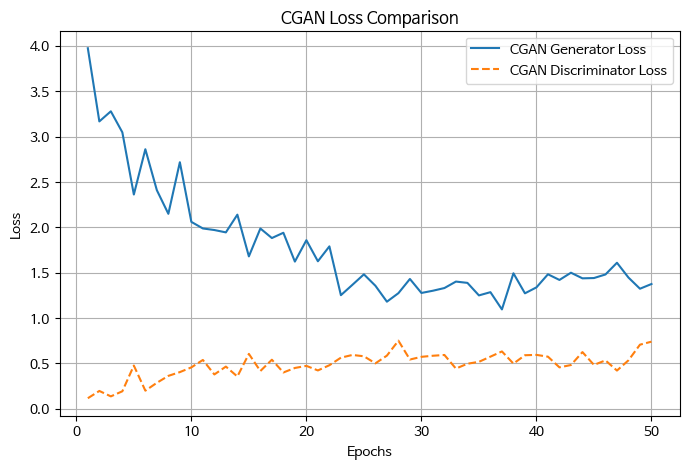

In [13]:
# CGAN Generator, Discriminator 시각화

epochs_range = range(1, len(g_loss_history_2) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, g_loss_history_2, linestyle='-', label="CGAN Generator Loss")
plt.plot(epochs_range, d_loss_history_2, linestyle='--', label="CGAN Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CGAN Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()

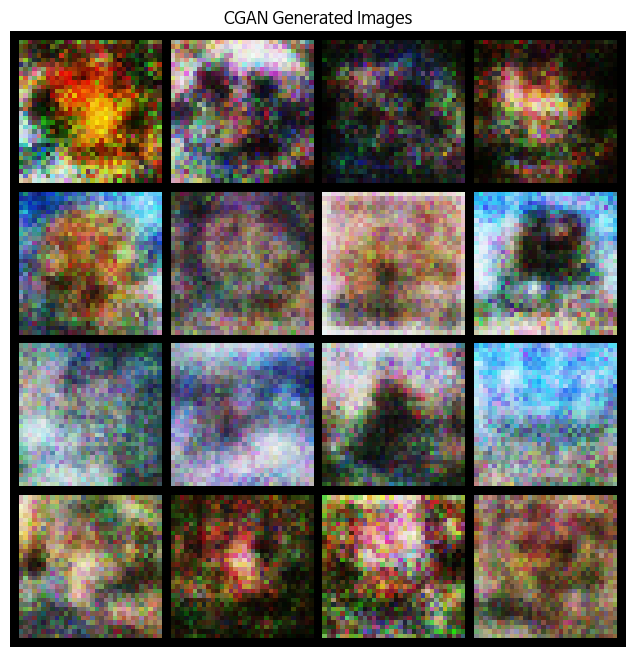

In [14]:
# 생성된 이미지 시각화

# 학습 결과 시각화
import torchvision.utils as vutils

def generate_images(generator, num_images=16, latent_dim=100, device="cuda"):
    generator.to(device)
    generator.eval()

    noise = torch.randn(num_images, latent_dim, device=device)
    random_labels = torch.randint(0, 100, (num_images,), device=device)

    with torch.no_grad():
        fake_images = generator(noise, random_labels)

    fake_images = (fake_images + 1) / 2

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("CGAN Generated Images")
    plt.imshow(vutils.make_grid(fake_images.cpu(), nrow=4, padding=2).permute(1, 2, 0))
    plt.show()

generate_images(cgan_generator, device=device)



# GAN 분석
GAN은 초기 Epoch에서 Generator가 빠르게 Discriminator를 속이면서 손실이 크게 감소하였고 학습이 진행됨에 따라 두 모델이 균형을 유지하며 어느 정도 안정화되는 모습을 보였다. 그러나 중반 이후 Generator의 손실이 다시 높아지는 불안정성을 보였고 결국 최적의 상태에 도달하지는 못 한 것 같다. 전체적으로 GAN의 학습은 어느 정도 성공적이었으나 충분한 안정성 확보는 부족했다. 내가 학습 속도를 위해 batch size를 줄인 것이 지금 당장에서 느껴지는이유라고 생각한다.

# 나의 실수
## 생성 이미지에 대한 분석
GAN을 이용해 생성한 이미지는 CIFAR100 데이터셋과 비슷한 구조를 가지며 색상과 기본 형태가 어느 정도(?) 나타났으나 세부 디테일 표현이 부족하였다고 느꼈다. 이는 Generator가 충분히 학습되지 못했거나 Epoch 수가 부족했을 가능성을 시사한다. 학습 속도를 위해 batch size를 크게 하지 않은 것도 결과 정확도면에서 안정성이 떨어졌을 것이라고 본다.

CGAN의 생성 이미지는 예상과 달리 명확한 클래스 구분 없이 매우 노이즈가 많은 형태로 나타났다. 실은 내가 실수한 부분인데, 학습 과정에서 사용한 CGAN 모델의 입력 데이터 처리 과정에서 실수가 있었기 때문으로 추정된다. 옵티마이저 역시 GAN의 설정을 그대로 사용하여 CGAN 학습에 부적합했다. 이러한 문제점을 보완하여 학습을 다시 수행하면 보다 안정적이고 원하는 클래스에 따라 명확한 이미지를 생성할 수 있을 것으로 기대된다.